# This notebook is to extract cluster with the most DE from network and run it through embedding

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
import seaborn as sns
import networkx as nx
from sys import platform 
from scipy.stats import ttest_ind
from src.eda.subset_network import subset_network
from src.eda.eda_functions import *
from src.eda.process_phenotype import *
from src.embedding.network_embedding import network_embedding
from functools import reduce
import umap
import time
from sklearn.model_selection import train_test_split
from harness.test_harness_class import TestHarness
from harness.utils.parsing_results import *
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.rocklin_models import logistic_classifier
from harness.th_model_instances.perovskite_models.xgboost import gradient_boosted_tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

In [3]:
tom_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0)
comm_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/network_louvain_default.csv')

In [4]:
deseq = pd.read_excel(prefix + '/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')
deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])

## Subset network method 1: choose the nodes from a non-DE module (e.g. 1, 2, 3, 5 or others) and top 100 DE from module 4

In [67]:
comm_df.louvain_label.unique()

array([1, 2, 5, 6, 0, 4, 3, 7, 8, 9], dtype=int64)

In [107]:
import random
import networkx as nx
def get_subnetwork1(module, num_genes, min_weight, tom_df = tom_df, comm_df = comm_df, deseq = deseq, plot_hist = True):
    '''This function subset the whole network by taking the top num_genes DE from module 4 and same number of nodes from 1 of the non-DE module in the original network
    module: the non-DE module to choose from
    num_genes: number of genes to subset from the two modules
    tom_df: whole network tom file
    comm_df: louvain community label file
    deseq: DE file
    return subnetwork with edges joined together as an adjacency df
    '''
    module4_tom = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/other data/cluster4_TOM.csv', index_col = 0)
    other_module_tom = get_module_df(tom_df, comm_df, module)
    m4_top100_nodes = deseq[deseq.id.isin(module4_tom.columns)][['id', 'abs_log2FC']].sort_values('abs_log2FC', ascending = False).reset_index(drop = True)[:num_genes]['id']
    random.seed(1)
    other_module_nodes = random.sample(other_module_tom.columns.tolist(), num_genes) # has randomness so I set a seed in the line above to remove the randomness
    G_sub_list = []
    edges = 0
    for gene in m4_top100_nodes: # iterate through the nodes
        gene_subnet = tom_df[gene][tom_df[gene] > min_weight] # set weight to choose neighbors from the whole network to could get nodes from other modules as well
        gene_edgelist = pd.DataFrame({'source':gene, 'target':gene_subnet.index, 'weight':gene_subnet.values})
        edges += len(gene_subnet)
        G_sub = nx.convert_matrix.from_pandas_edgelist(gene_edgelist, 'source', 'target', 'weight') # convert from edgelist to graph
        G_sub_list.append(G_sub)

    for gene in other_module_nodes:
        gene_subnet = tom_df[gene][tom_df[gene] > min_weight]
        gene_edgelist = pd.DataFrame({'source':gene, 'target':gene_subnet.index, 'weight':gene_subnet.values})
        edges += len(gene_subnet)
        G_sub = nx.convert_matrix.from_pandas_edgelist(gene_edgelist, 'source', 'target', 'weight')
        G_sub_list.append(G_sub)
    print('Number of edges:',edges)
    
    G_joined = reduce(lambda x,y:nx.compose(x, y), G_sub_list)
    joined_df = nx.convert_matrix.to_pandas_adjacency(G_joined)
    if plot_hist == True:
        plot_module_hist(joined_df, f'num_genes={num_genes},min_weight={min_weight}')
    return G_joined, joined_df

In [92]:
def plot_module_hist(adjacency_df, title, comm_df = comm_df):
    plt.hist(comm_df[comm_df.id.isin(adjacency_df.columns)].louvain_label) # show the distributions of the nodes after subsetting
    plt.title(title)
    plt.xlabel('module id')
    plt.ylabel('number of genes')
    x_min = comm_df.louvain_label.min()
    x_max = comm_df.louvain_label.max()
    plt.xticks(np.arange(x_min, x_max + 1, 1.0))
    plt.show()
    plt.close()

Number of edges: 58083


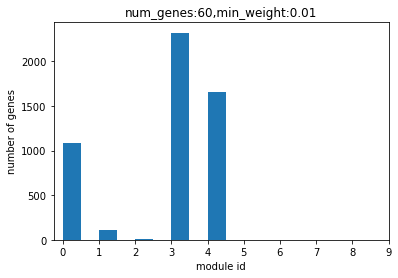

Number of edges: 38823


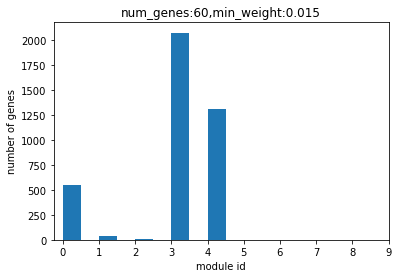

Number of edges: 28473


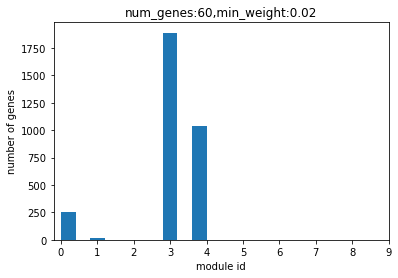

Number of edges: 84243


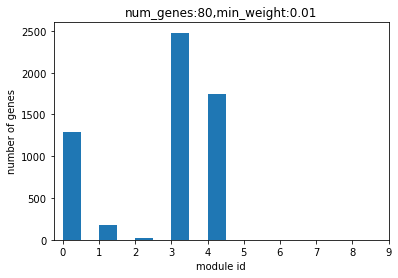

Number of edges: 57866


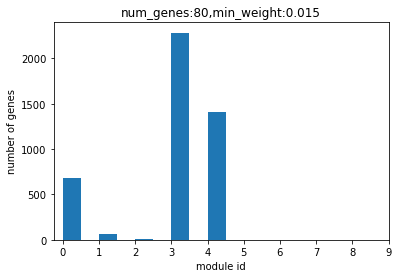

Number of edges: 43332


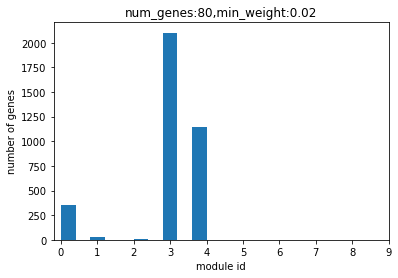

Number of edges: 112563


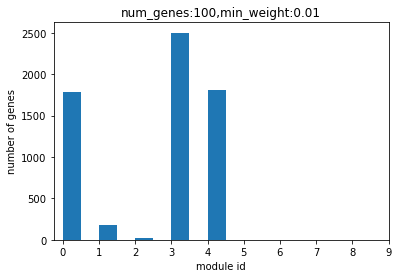

Number of edges: 77439


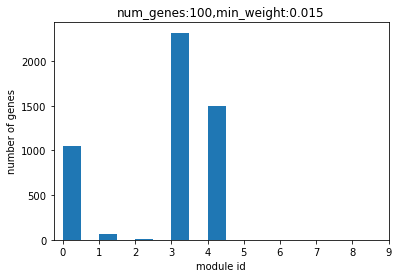

Number of edges: 57965


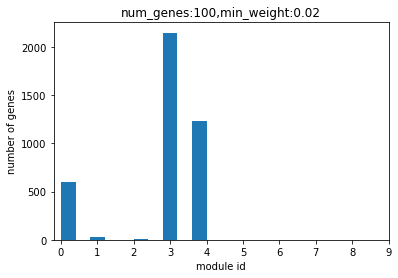

time delta: 81.52920413017273 seconds


In [85]:
# Test using fewer gene_num and lower weight cutoff to subselect genes
start = time.time()
for gene_num in [60,80,100]:
    for weight in [0.01, 0.015, 0.02]:
        module3_n_4_df = get_subnetwork1(3, gene_num, weight)
end = time.time()
print(f'time delta: {end-start} seconds')

Number of edges: 76334


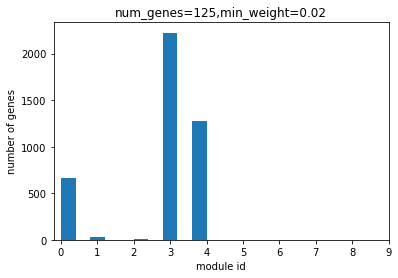

Number of edges: 60395


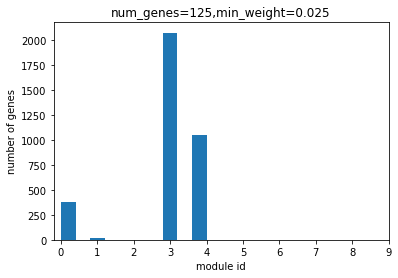

Number of edges: 89152


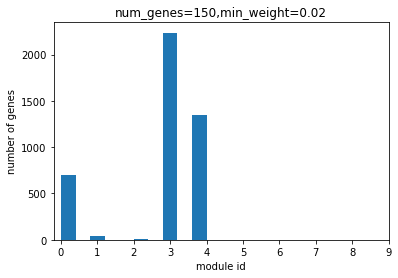

Number of edges: 70175


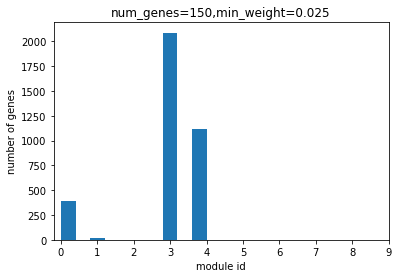

time delta: 120.3098669052124 seconds


In [94]:
# Test using more gene_num and higher weight cutoff to subselect genes
start = time.time()
for gene_num in [125, 150]:
    for weight in [0.02, 0.025]:
        module3_n_4_df = get_subnetwork1(3, gene_num, weight)
end = time.time()
print(f'time delta: {end-start} seconds')

In [6]:
def get_module_df(network_df, community_df, cluster):
    cluster_genes = community_df[community_df.louvain_label == cluster].id
    cluster_tom = network_df[cluster_genes]
    cluster_tom = cluster_tom[cluster_tom.index.isin(cluster_genes)]
    return cluster_tom

In [106]:
def get_subnetwork2(num_genes, min_weight, tom_df = tom_df, comm_df = comm_df, deseq = deseq, plot_hist = True):
    '''This function subset the whole network by taking the top num_genes DE from module 4 
    module: the non-DE module to choose from
    tom_df: whole network tom file
    comm_df: louvain community label file
    deseq: DE file
    return subnetwork with edges joined together as an adjacency df
    '''
    module4_tom = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/other data/cluster4_TOM.csv', index_col = 0)
    m4_top_nodes = deseq[deseq.id.isin(module4_tom.columns)][['id', 'abs_log2FC']].sort_values('abs_log2FC', ascending = False).reset_index(drop = True)[:num_genes]['id']

    G_sub_list = []
    edges = 0
    for gene in m4_top_nodes: # iterate through the nodes
        gene_subnet = tom_df[gene][tom_df[gene] > min_weight] # set weight to choose neighbors
        gene_edgelist = pd.DataFrame({'source':gene, 'target':gene_subnet.index, 'weight':gene_subnet.values})
        edges += len(gene_subnet)
        G_sub = nx.convert_matrix.from_pandas_edgelist(gene_edgelist, 'source', 'target', 'weight') # convert from edgelist to graph
        G_sub_list.append(G_sub)

    print('Number of edges:',edges)
    G_joined = reduce(lambda x,y:nx.compose(x, y), G_sub_list)
    joined_df = nx.convert_matrix.to_pandas_adjacency(G_joined)
    if plot_hist == True:
        plot_module_hist(joined_df, f'num_genes={num_genes},min_weight={min_weight}')
    return G_joined, joined_df

Number of edges: 56610


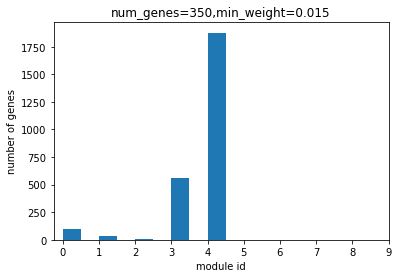

Number of edges: 44446


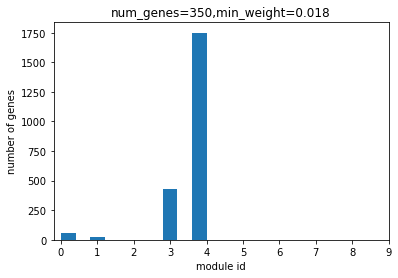

Number of edges: 64944


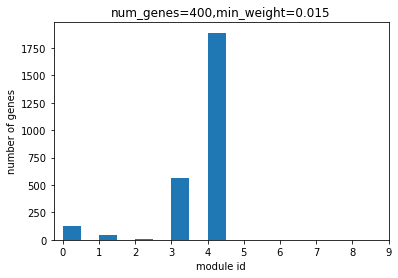

Number of edges: 51009


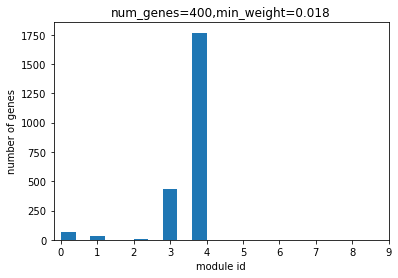

Number of edges: 74566


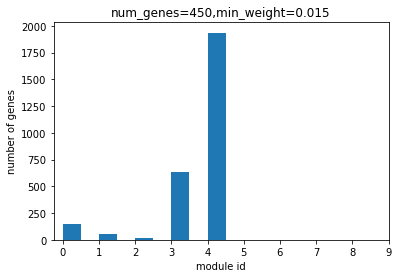

Number of edges: 58576


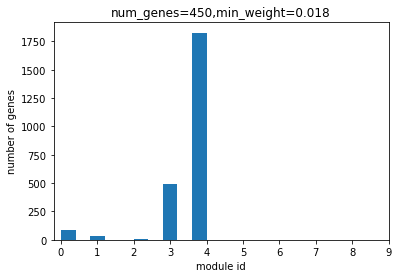

time delta: 270.80796122550964 seconds


In [100]:
start = time.time()
for gene_num in [350, 400, 450]:
    for weight in [0.015, 0.018]:
        module4_df = get_subnetwork2(gene_num, weight)
end = time.time()
print(f'time delta: {end-start} seconds')

# Run embedding (4 sets of parameters)

In [108]:
G_3_n_4, module3_n_4_df = get_subnetwork1(3, 150, 0.02, plot_hist = False)

Number of edges: 89152


In [109]:
G4, module4_df = get_subnetwork2(450, 0.015, plot_hist = False)

Number of edges: 74566


In [116]:
module3_n_4_df.head()

,ENSG00000166819,ENSG00000162407,ENSG00000162599,ENSG00000213625,ENSG00000172380,ENSG00000116729,ENSG00000079335,ENSG00000170989,ENSG00000168710,ENSG00000134250,ENSG00000213240,ENSG00000143603,ENSG00000163346,ENSG00000143149,ENSG00000117592,ENSG00000135838,ENSG00000116747,ENSG00000092969,ENSG00000162909,ENSG00000143514,ENSG00000143819,ENSG00000135744,ENSG00000077585,ENSG00000148482,ENSG00000148498,ENSG00000165449,ENSG00000165730,ENSG00000148730,ENSG00000148672,ENSG00000148700,ENSG00000119927,ENSG00000229847,ENSG00000170370,ENSG00000130413,ENSG00000072952,ENSG00000187079,ENSG00000152268,ENSG00000205213,ENSG00000007372,ENSG00000110436,ENSG00000110090,ENSG00000184384,ENSG00000137693,ENSG00000165478,ENSG00000008394,ENSG00000123096,ENSG00000139132,ENSG00000139644,ENSG00000185432,ENSG00000111058,ENSG00000136044,ENSG00000111783,ENSG00000121742,ENSG00000150907,ENSG00000179399,ENSG00000139800,ENSG00000197324,ENSG00000100852,ENSG00000151322,ENSG00000073712,ENSG00000119711,ENSG00000140022,ENSG00000140455,ENSG00000109113,ENSG00000141736,ENSG00000153944,ENSG00000120063,ENSG00000154217,ENSG00000234899,ENSG00000125398,ENSG00000161533,ENSG00000168461,ENSG00000171885,ENSG00000134769,ENSG00000141469,ENSG00000167315,ENSG00000134042,ENSG00000129353,ENSG00000178904,ENSG00000169006,ENSG00000119737,ENSG00000115380,ENSG00000198075,ENSG00000153208,ENSG00000071967,ENSG00000116044,ENSG00000088826,ENSG00000124145,ENSG00000132825,ENSG00000183255,ENSG00000182902,ENSG00000183579,ENSG00000186951,ENSG00000100427,ENSG00000114166,ENSG00000056736,ENSG00000144730,ENSG00000168309,ENSG00000178075,ENSG00000259976,ENSG00000181722,ENSG00000031081,ENSG00000144908,ENSG00000114698,ENSG00000169860,ENSG00000241732,ENSG00000114790,ENSG00000181449,ENSG00000187068,ENSG00000127249,ENSG00000163285,ENSG00000084093,ENSG00000080493,ENSG00000172493,ENSG00000163110,ENSG00000138696,ENSG00000164039,ENSG00000164089,ENSG00000138685,ENSG00000151012,ENSG00000248249,ENSG00000164188,ENSG00000079215,ENSG00000250155,ENSG00000113594,ENSG00000134352,ENSG00000164199,ENSG00000164292,ENSG00000145721,ENSG00000155324,ENSG00000250602,ENSG00000164904,ENSG00000113732,ENSG00000197977,ENSG00000152661,ENSG00000111907,ENSG00000146409,ENSG00000051620,ENSG00000135540,ENSG00000111961,ENSG00000105855,ENSG00000106571,ENSG00000146648,ENSG00000105854,ENSG00000004799,ENSG00000158467,ENSG00000147475,ENSG00000147509,ENSG00000046889,ENSG00000085719,ENSG00000169439,ENSG00000132541,ENSG00000104447,ENSG00000148053,ENSG00000119471,ENSG00000136869,ENSG00000148175,ENSG00000101871,ENSG00000189221,ENSG00000089472,ENSG00000079482,ENSG00000067177,ENSG00000171100,ENSG00000096060,ENSG00000117519,ENSG00000107968,ENSG00000122862,ENSG00000107738,ENSG00000197142,ENSG00000185201,ENSG00000142089,ENSG00000067182,ENSG00000060138,ENSG00000090376,ENSG00000131981,ENSG00000131873,ENSG00000077238,ENSG00000125148,ENSG00000187193,ENSG00000168610,ENSG00000129657,ENSG00000184557,ENSG00000171051,ENSG00000115594,ENSG00000115112,ENSG00000018280,ENSG00000101276,ENSG00000101187,ENSG00000163884,ENSG00000137462,ENSG00000145623,ENSG00000112312,ENSG00000221869,ENSG00000147872,ENSG00000130222,ENSG00000156313,ENSG00000028137,ENSG00000162496,ENSG00000162493,ENSG00000159189,ENSG00000173369,ENSG00000088280,ENSG00000142733,ENSG00000000938,ENSG00000117228,ENSG00000162645,ENSG00000224081,ENSG00000155366,ENSG00000197747,ENSG00000163191,ENSG00000143570,ENSG00000143545,ENSG00000160712,ENSG00000160691,ENSG00000158710,ENSG00000158769,ENSG00000143226,ENSG00000235750,ENSG00000133048,ENSG00000165507,ENSG00000138193,ENSG00000107438,ENSG00000077150,ENSG00000151929,ENSG00000185885,ENSG00000148926,ENSG00000085063,ENSG00000156587,ENSG00000149131,ENSG00000137507,ENSG00000196954,ENSG00000149573,ENSG00000110799,ENSG00000111321,ENSG00000182326,ENSG00000159403,ENSG00000177575,ENSG00000134531,ENSG00000177119,ENSG00000123374,ENSG00000152137,ENSG00000136167,ENSG00000198805,ENSG00000100906,ENSG00000100504,ENSG00000197249,ENSG00000137767,ENSG00000182718,ENSG00000175318,ENSG00000205364

In [122]:
deseq['impact'] = 0
deseq.loc[deseq['abs_log2FC'] > 0.1, 'impact'] = 1

In [124]:
deseq[deseq.id.isin(module4_df.columns)]['impact'].value_counts()

0    1982
1     569
Name: impact, dtype: int64

In [111]:
subnetwork_names = ['m3+4_150_0.02','m4_450_0.015']
for i, G in enumerate([G_3_n_4, G4]):
    emb_df = network_embedding(G, 16, 100, 10, 'C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec17', subnetwork_names[i]) # use the network with 5k edges as a test (less computationally intensive)

Computing transition probabilities:   0%|              | 0/2781 [00:00<?, ?it/s]

embedding data saved


Generating walks (CPU: 1): 100%|██████████████| 100/100 [05:14<00:00,  3.15s/it]


embedding data saved


In [114]:
file_path = 'C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec17/'
emb_list = []
kmeans_list = []
for file in os.listdir(file_path):
    emb = pd.read_csv(file_path + file, index_col = 0)
    emb_list.append(emb)
    kmeans_list.append(run_kmeans(emb, 5))

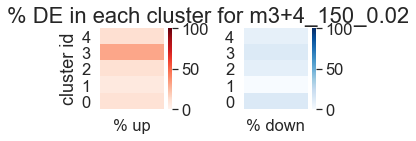

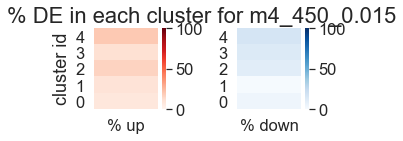

In [115]:
for i in range(len(kmeans_list)):
    cluster_DE_perc(kmeans_list[i], 'kmean_label', subnetwork_names[i])

In [ ]:
th_path = 'F:/data/emb_ML_Dec17'
feature_cols = processed_emb_dfs[0].columns[:64].tolist()
for i, emb_df in enumerate(processed_emb_dfs):
    emb_df['index_col'] = range(len(emb_df))
    run_ml(emb_df, output_dir=th_path, description=parameters[i],feature_cols_to_use=feature_cols, 
           models_to_test = [logistic_classifier, random_forest_classification, gradient_boosted_tree], 
           feature_cols_to_normalize=feature_cols, sparse_cols_to_use=None)

In [ ]:
parameters = []
kmeans_list = []
for length in [16, 64]:
    for num_walk in [100, 300]:
        emb_df = network_embedding(G_joined, length, num_walk, 10, 'C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec1', 'cluster3+4') # use the network with 5k edges as a test (less computationally intensive)
        kmeans_list.append(run_kmeans(emb_df, 2)) # run k means 
        parameters.append(f'length={length},num_walk={num_walk}') # add the parameter name to the parameters list

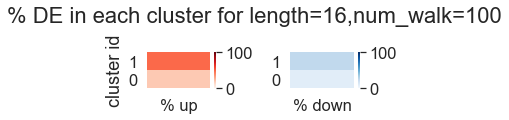

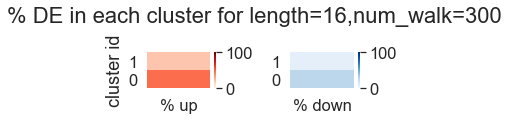

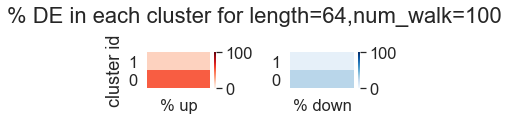

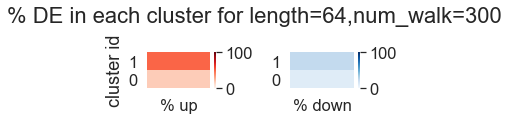

In [429]:
for i in range(len(kmeans_list)):
    cluster_DE_perc(kmeans_list[i], 'kmean_label', parameters[i])

In [5]:
def umap_embedding(emb_df, emb_name, deseq = deseq):
    umap_emb = umap.UMAP(n_neighbors = 8, min_dist = 0.3, random_state=42).fit_transform(emb_df)
    umap_df = pd.DataFrame(umap_emb, index = emb_df.index)
    umap_deseq_df = pd.merge(umap_df, deseq, left_index = True, right_on = 'id')
    sns.set(rc={'figure.figsize':(6,4)})
    sns.set(font_scale = 1.2)
    sns.set_style('white')
    cmap = sns.color_palette('RdBu_r', as_cmap=True)
    f, ax = plt.subplots()
    points = ax.scatter(umap_deseq_df.loc[:,0], umap_deseq_df.loc[:,1], c=umap_deseq_df.loc[:,'log2FoldChange'], 
                        s=2, cmap=cmap, vmin = -0.3, vmax = 0.3)
    f.colorbar(points)
    plt.title(f'{emb_name} embedding color by log2FC');

## Check k mean cluster and alcohol phenotype correlation

In [25]:
os.chdir('C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec1')
emb_dfs = []
# kmeans_list = []
for file in os.listdir():
    emb = pd.read_csv(file, index_col = 0)
    emb_dfs.append(emb)
#     kmeans_list.append(run_kmeans(emb, 2))

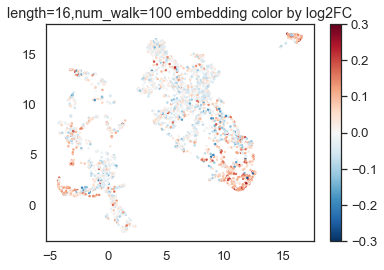

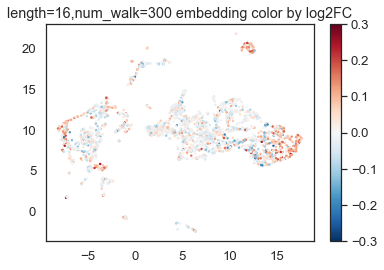

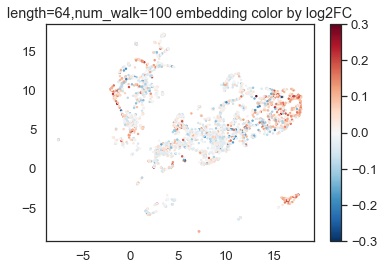

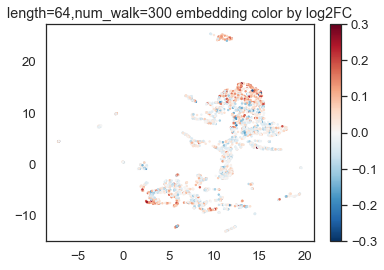

In [8]:
for i, emb in enumerate(emb_dfs):
    umap_embedding(emb, parameters[i])

In [16]:
emb_4 = pd.read_csv('embedded_len64_walk300_cluster3+4.csv', index_col = 0)
kmean_4 = run_kmeans(emb_4, 2)

In [20]:
comm_df_3_n_4 = comm_df[comm_df.id.isin(kmean_4.id)]

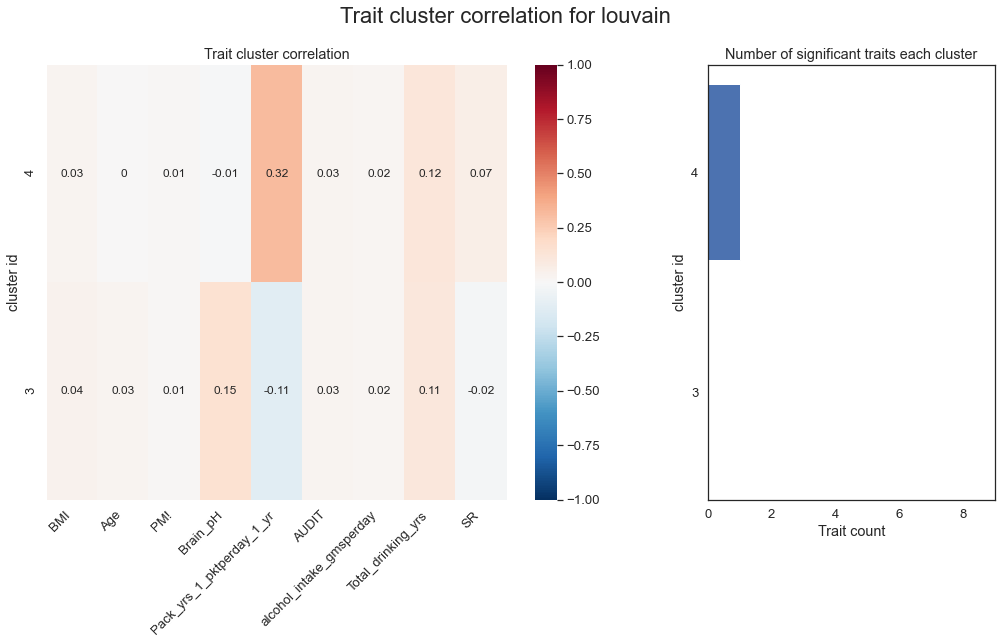

In [22]:
cluster_phenotype_corr(comm_df_3_n_4, 'louvain_label', 'louvain')

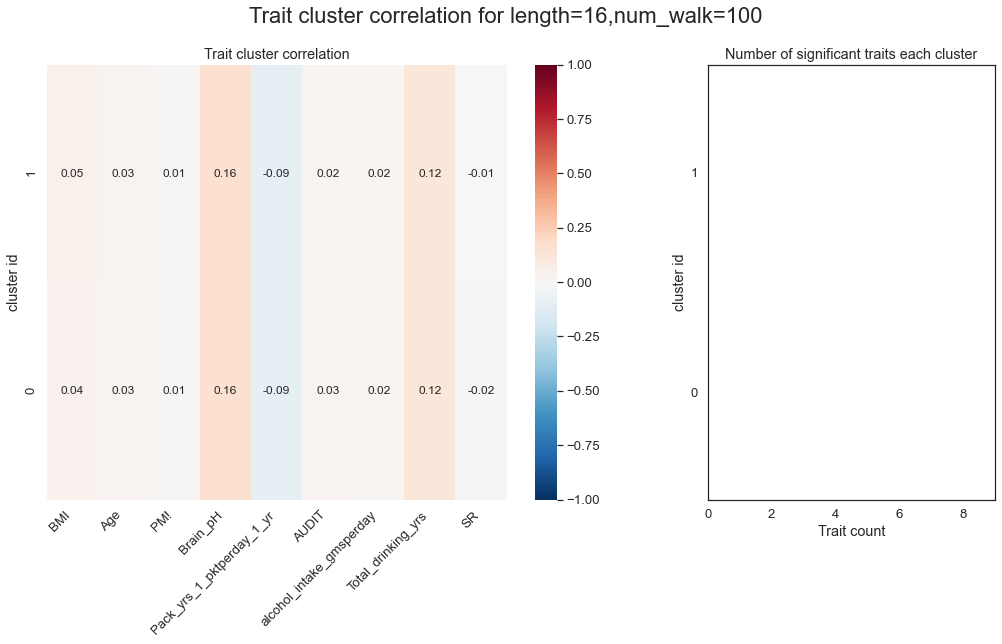

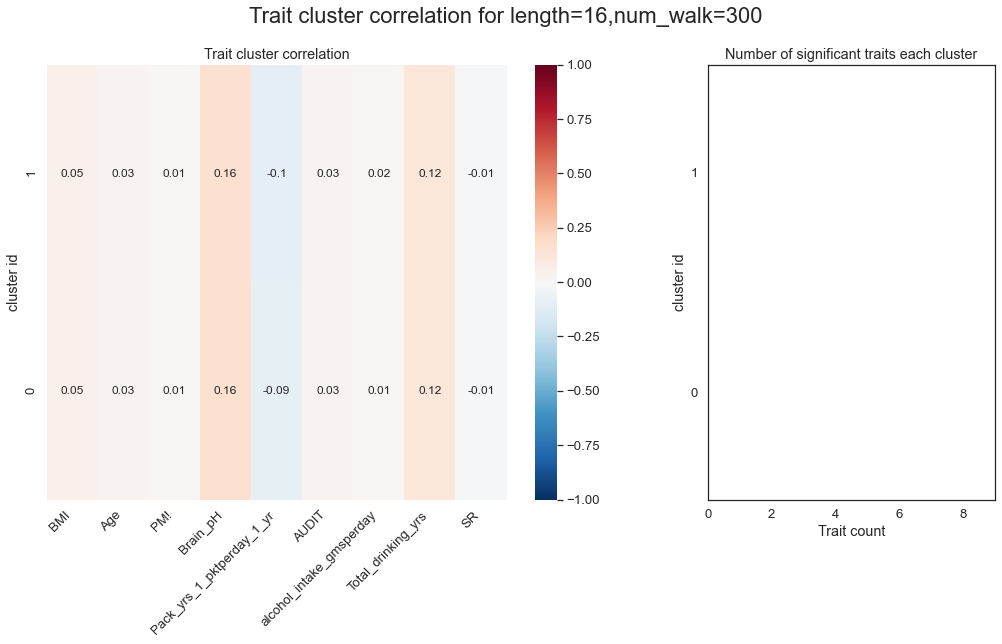

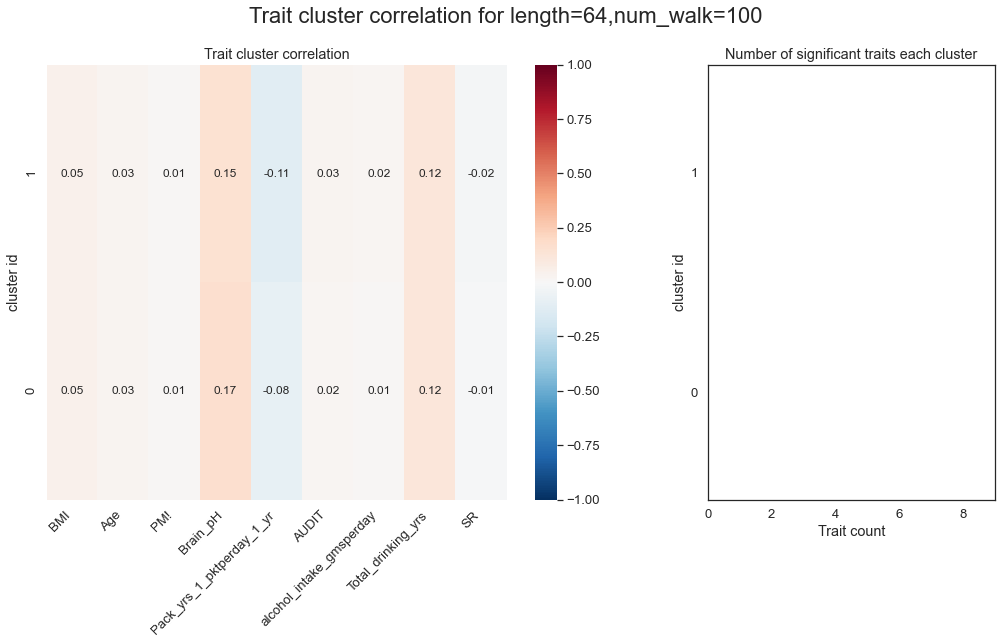

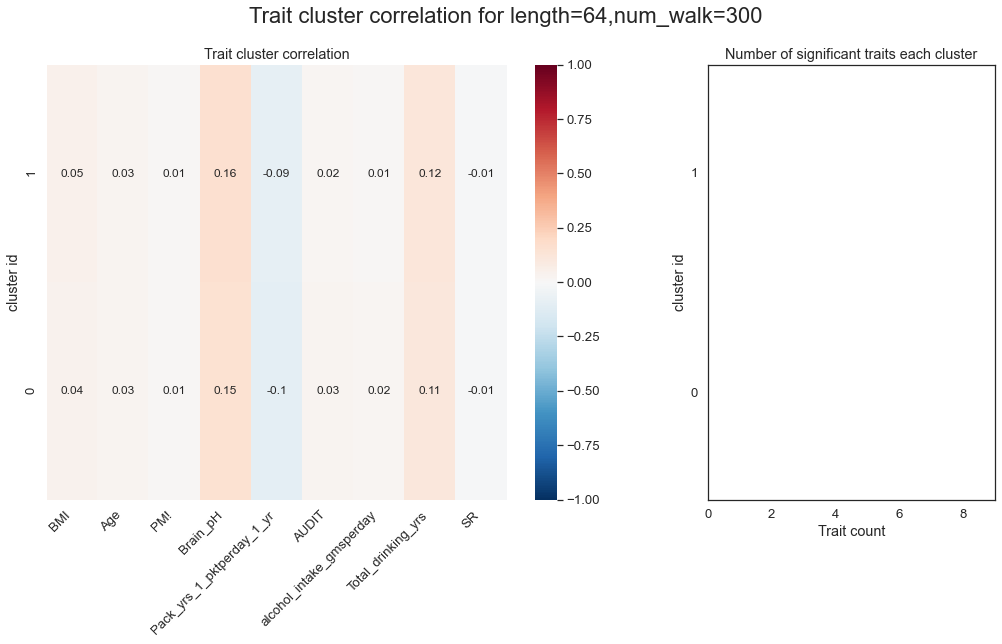

In [28]:
for i, kmeans in enumerate(kmeans_list):
    cluster_phenotype_corr(kmeans, 'kmean_label', parameters[i])

## check impact/non-impact genes and louvain cluster id in the embedding

In [15]:
cluster3_genes = cluster3_tom.columns.tolist()
cluster4_genes = cluster4_tom.columns.tolist()

In [ ]:
umap_emb = umap.UMAP(n_neighbors = 8, min_dist = 0.3, random_state=42).fit_transform(emb)
umap_df = pd.DataFrame(umap_emb, index = emb.index)

In [20]:
umap_df['louvain_label'] = 0
umap_df.loc[umap_df.index.isin(cluster3_genes), 'louvain_label'] = 3
umap_df.loc[umap_df.index.isin(cluster4_genes), 'louvain_label'] = 4

In [27]:
umap_labeled = pd.merge(umap_df, deseq, left_index = True, right_on = 'id')

In [28]:
umap_labeled['impact']= 1
umap_labeled.loc[umap_labeled['abs_log2FC'].between(-0.1,0.1), 'impact'] = 0

In [31]:
umap_labeled['impact_cluster'] = 0
umap_labeled.loc[(umap_labeled['louvain_label'] == 3) & (umap_labeled['impact'] == 0), 'impact_cluster'] = '3_non_impact'
umap_labeled.loc[(umap_labeled['louvain_label'] == 3) & (umap_labeled['impact'] == 1), 'impact_cluster'] = '3_impact'
umap_labeled.loc[(umap_labeled['louvain_label'] == 4) & (umap_labeled['impact'] == 0), 'impact_cluster'] = '4_non_impact'
umap_labeled.loc[(umap_labeled['louvain_label'] == 4) & (umap_labeled['impact'] == 1), 'impact_cluster'] = '4_impact'

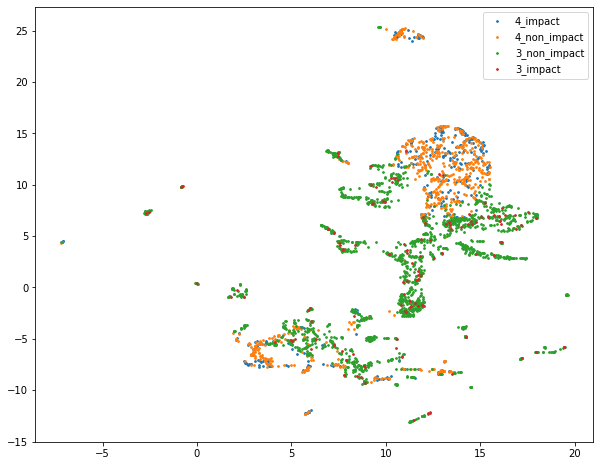

In [42]:
plt.figure(figsize=(10,8))
for group in umap_labeled['impact_cluster'].unique():
    plt.scatter(umap_labeled[umap_labeled['impact_cluster'] == group][0], umap_labeled[umap_labeled['impact_cluster'] == group][1], s = 3, label = group)
plt.legend()

In [39]:
def process_emb_for_ML(embedding_df):
    embedding_labeled_df = pd.merge(embedding_df, deseq, left_index = True, right_on = 'id')
    embedding_labeled_df['impact'] = 1
    embedding_labeled_df.loc[embedding_labeled_df['log2FoldChange'].between(-0.1, 0.1), 'impact'] = 0
    return embedding_labeled_df

In [40]:
processed_emb_dfs = list(map(process_emb_for_ML, emb_dfs))

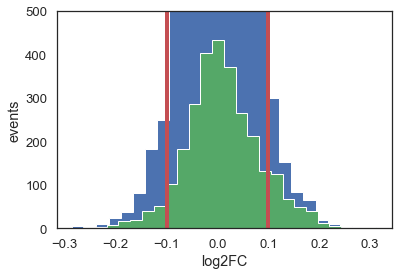

In [53]:
# checking log2FC distribution from deseq and cluster 4 
plt.hist(deseq.log2FoldChange, bins = 25, histtype='stepfilled')
plt.hist(deseq[deseq.id.isin(processed_emb_dfs[0].id)].log2FoldChange, bins = 25, histtype='stepfilled', color = 'g')
plt.ylim(0, 500)
plt.vlines(-0.1, 0, 510, color = 'r', linewidth=4)
plt.vlines(0.1, 0, 510, color = 'r', linewidth=4)
plt.ylabel('events')
plt.xlabel('log2FC');

In [100]:
def run_ml(embedding_data, output_dir, description,
           feature_cols_to_use, models_to_test, repeat=6, feature_cols_to_normalize=None,
           sparse_cols_to_use=None, pred_col='impact'):
    th_path = output_dir
    th = TestHarness(output_location = th_path)
    num_sample = embedding_data['impact'].value_counts().min()
    for i in range(repeat):
        emb_subset = embedding_data.groupby('impact').sample(num_sample).reset_index() # subset to have equal samples in the two classes
        train_df, test_df = train_test_split(emb_subset, test_size = 0.2)
        normalize = False
        if feature_cols_to_normalize:
            normalize = True

        for model in models_to_test:
            th.run_custom(function_that_returns_TH_model = model,
                          dict_of_function_parameters={}, training_data = train_df,
                          testing_data = test_df, description = description,
                          target_cols=pred_col, feature_cols_to_use = feature_cols_to_use,
                          index_cols = ['index_col'], normalize = normalize,
                          feature_cols_to_normalize = feature_cols_to_normalize, feature_extraction = False,
                          sparse_cols_to_use=sparse_cols_to_use, predict_untested_data=False)

## ML1 using embedding to predict impact/non-impact 

In [110]:
th_path = 'F:/data/emb_ML_Dec2'
feature_cols = processed_emb_dfs[0].columns[:64].tolist()
for i, emb_df in enumerate(processed_emb_dfs):
    emb_df['index_col'] = range(len(emb_df))
    run_ml(emb_df, output_dir=th_path, description=parameters[i],feature_cols_to_use=feature_cols, 
           models_to_test = [logistic_classifier, random_forest_classification, gradient_boosted_tree], 
           feature_cols_to_normalize=feature_cols, sparse_cols_to_use=None)


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:25:53
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.01 seconds
Testing time was: 0.00 seconds
Run finished at 14:25:53. Total run time = 0.08 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:25:53
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.53 seconds
Testing time was: 0.08 seconds
Run finished at 14:25:54. Total run time = 0.68 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:25:54
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.05 seconds
Testing time was: 0.01 seconds
Run finished at 14:25:57. Total run time = 3.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------------

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:25:58
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.54 seconds
Testing time was: 0.08 seconds
Run finished at 14:25:58. Total run time = 0.70 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:25:58
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.21 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:02. Total run time = 3.29 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------------

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:26:02
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.53 seconds
Testing time was: 0.08 seconds
Run finished at 14:26:02. Total run time = 0.68 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:03
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.11 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:06. Total run time = 3.20 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------------

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:26:06. Total run time = 0.18 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:26:06
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.56 seconds
Testing time was: 0.08 seconds
Run finished at 14:26:07. Total run time = 0.74 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:07
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.07 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:10. Total run time = 3.15 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:26:10. Total run time = 0.09 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:26:10
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.51 seconds
Testing time was: 0.09 seconds
Run finished at 14:26:11. Total run time = 0.80 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:11
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.06 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:14. Total run time = 3.14 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:26:14. Total run time = 0.09 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:26:15
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.08 seconds
Run finished at 14:26:15. Total run time = 0.68 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:15
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.14 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:18. Total run time = 3.22 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:26:19. Total run time = 0.09 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:26:19
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.09 seconds
Run finished at 14:26:19. Total run time = 0.69 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:19
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.09 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:23. Total run time = 3.18 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:26:23. Total run time = 0.09 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:26:23
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.51 seconds
Testing time was: 0.08 seconds
Run finished at 14:26:24. Total run time = 0.77 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:24
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.10 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:27. Total run time = 3.19 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:26:27. Total run time = 0.09 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:26:27
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.08 seconds
Run finished at 14:26:28. Total run time = 0.68 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:28
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.10 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:31. Total run time = 3.27 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.52 seconds
Testing time was: 0.08 seconds
Run finished at 14:26:32. Total run time = 0.68 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:32
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.03 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:35. Total run time = 3.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:26:35
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.01 seconds
Testing time was: 0.01 seconds


C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:26:35. Total run time = 0.14 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:26:36
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.08 seconds
Run finished at 14:26:36. Total run time = 0.69 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:36
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.01 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:39. Total run time = 3.12 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"



Run finished at 14:26:40. Total run time = 0.10 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:26:40
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.08 seconds
Run finished at 14:26:40. Total run time = 0.80 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:41
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.04 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:44. Total run time = 3.24 seconds
^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.52 seconds
Testing time was: 0.08 seconds
Run finished at 14:26:45. Total run time = 0.69 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:45
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.07 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:48. Total run time = 3.29 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:26:48
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.01 seconds
Testing time was: 0.00 seconds
Run finished 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.51 seconds
Testing time was: 0.09 seconds
Run finished at 14:26:49. Total run time = 0.69 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:49
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.25 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:52. Total run time = 3.36 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:26:52
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.01 seconds
Testing time was: 0.01 seconds


C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:26:53. Total run time = 0.10 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:26:53
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.09 seconds
Run finished at 14:26:53. Total run time = 0.69 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:53
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.07 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:57. Total run time = 3.18 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.01 seconds
Testing time was: 0.01 seconds
Run finished at 14:26:57. Total run time = 0.10 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:26:57
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.55 seconds
Testing time was: 0.09 seconds
Run finished at 14:26:58. Total run time = 0.74 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:26:58
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.14 seconds
Testing time was: 0.01 seconds
Run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:27:01
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.08 seconds
Run finished at 14:27:02. Total run time = 0.71 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:27:02
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.11 seconds
Testing time was: 0.01 seconds
Run finished at 14:27:05. Total run time = 3.21 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------------

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Testing time was: 0.01 seconds
Run finished at 14:27:05. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:27:06
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.53 seconds
Testing time was: 0.08 seconds
Run finished at 14:27:06. Total run time = 0.72 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:27:06
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.04 seconds
Testing time was: 0.01 seconds
Run finished at 14:27:09. Total run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:27:10. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:27:10
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.09 seconds
Run finished at 14:27:11. Total run time = 0.83 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:27:11
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.07 seconds
Testing time was: 0.01 seconds
Run finished at 14:27:14. Total run time = 3.30 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Starting Classification training...
Training time was: 0.61 seconds
Testing time was: 0.09 seconds
Run finished at 14:27:15. Total run time = 0.80 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:27:15
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.10 seconds
Testing time was: 0.01 seconds
Run finished at 14:27:18. Total run time = 3.23 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:27:18
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.01 seconds
Testing 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"



Starting run of model random_forest_classification at time 14:27:19
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.53 seconds
Testing time was: 0.08 seconds
Run finished at 14:27:19. Total run time = 0.73 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:27:19
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.07 seconds
Testing time was: 0.01 seconds
Run finished at 14:27:23. Total run time = 3.30 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:27:23
Normali

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:27:23
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.54 seconds
Testing time was: 0.09 seconds
Run finished at 14:27:24. Total run time = 0.85 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:27:24
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.30 seconds
Testing time was: 0.01 seconds
Run finished at 14:27:27. Total run time = 3.43 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------------

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Starting Classification training...
Training time was: 0.54 seconds
Testing time was: 0.09 seconds
Run finished at 14:27:28. Total run time = 0.75 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:27:28
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.33 seconds
Testing time was: 0.01 seconds
Run finished at 14:27:32. Total run time = 3.45 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:27:32
Normalizing training and testing splits...


C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Starting Classification training...
Training time was: 0.01 seconds
Testing time was: 0.01 seconds
Run finished at 14:27:32. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:27:32
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.53 seconds
Testing time was: 0.08 seconds
Run finished at 14:27:33. Total run time = 0.72 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:27:33
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.09 seconds

In [139]:
def plot_ML_results(th_path, description_list, output_dir = None):
    model_dict = {'random_forest_classification': 'Random Forest',
                  'gradient_boosted_tree': 'Gradient Boosted Tree',
                  'logistic_classifier': 'Logistic Regression'}
    sns.set(rc={'figure.figsize': (6, 4)}, font_scale=1.5)
    sns.set_style("white")
    for description in description_list:
        leaderboard_df = query_leaderboard(query={'Description':description},
                               th_output_location=th_path, loo=False, classification=True)
        leaderboard_df['Model Name'] = leaderboard_df['Model Name'].map(model_dict)
        leaderboard_df['Accuracy'] = 100*leaderboard_df['Accuracy']
        agg_acc = leaderboard_df.groupby('Model Name')['Accuracy'].mean()
        print('best accuracy', round(agg_acc.max()))
        ax = sns.boxplot(x = 'Model Name', y = 'Accuracy', data = leaderboard_df)
        ax.set(ylim = (0,100))
        plt.title(description)
        plt.xlabel('')
        plt.axhline(50, color = 'r')
        plt.xticks(rotation = 45, ha = 'right')
        plt.show()
        plt.close()

best accuracy 70


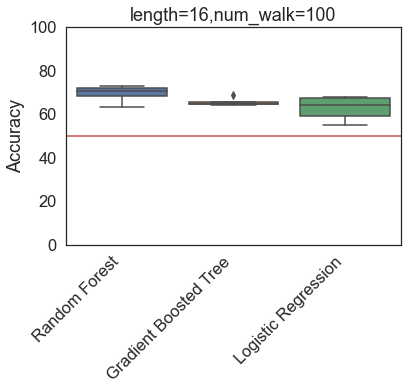

best accuracy 70


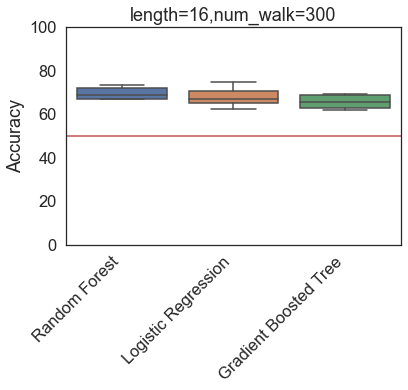

best accuracy 68


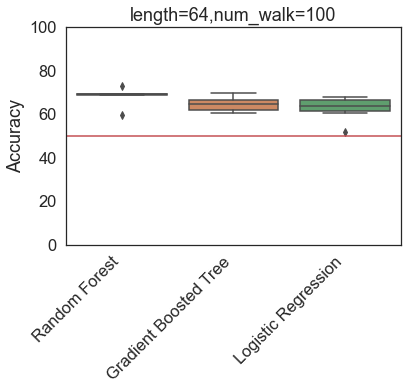

best accuracy 70


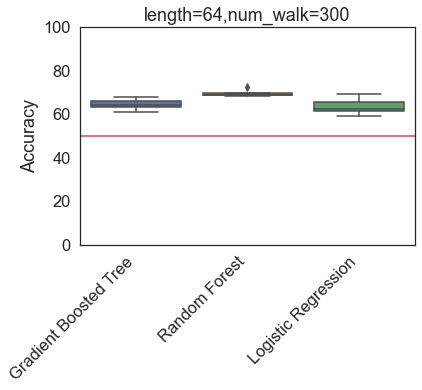

In [140]:
plot_ML_results(th_path, parameters)

## Determine if the ones that got correct classification were in one specific group like cluster 4 only 

In [60]:
# Since I didn't save the df used to run test-harness, a quick ML here so have df to label the louvain id for each data point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
rf = RandomForestClassifier()
emb_labeled = pd.merge(emb, deseq, left_index = True, right_on = 'id')
emb_labeled['impact'] = 1
emb_labeled.loc[emb_labeled['log2FoldChange'].between(-0.1, 0.1), 'impact'] = 0

In [62]:
emb_subset = emb_labeled.groupby(['impact']).sample(481).reset_index(drop = True)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(emb_subset, emb_subset['impact'], test_size = 0.2)
rf.fit(X_train.iloc[:,:64], y_train)

RandomForestClassifier()

In [73]:
rf.score(X_test.iloc[:,:64], y_test)

0.7357512953367875

In [75]:
test_predict = rf.predict(X_test.iloc[:,:64])
X_test['predict_impact'] = test_predict

In [92]:
X_test['louvain_label'] = 0
X_test.loc[X_test.id.isin(cluster3_genes), 'louvain_label'] = 3
X_test.loc[X_test.id.isin(cluster4_genes), 'louvain_label'] = 4

In [96]:
from sklearn.metrics import accuracy_score
print('accuracy for points from cluster 3')
accuracy_score(X_test[X_test.louvain_label == 3]['impact'], X_test[X_test.louvain_label == 3]['predict_impact'])

accuracy for points from cluster 3


0.7653061224489796

In [106]:
from sklearn.metrics import confusion_matrix

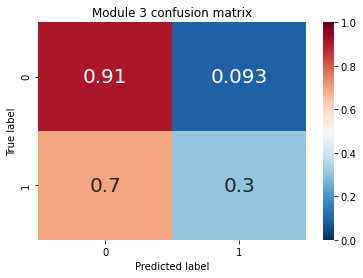

In [115]:
cm = confusion_matrix(X_test[(X_test.louvain_label == 3)]['impact'], X_test[(X_test.louvain_label == 3)]['predict_impact'], normalize='true')
sns.heatmap(cm, center = 0.5, vmin = 0, vmax = 1, cmap = 'RdBu_r', annot=True, annot_kws={'fontsize':20})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Module 3 confusion matrix');

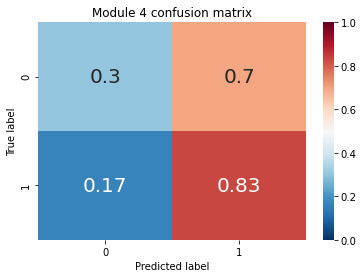

In [116]:
cm = confusion_matrix(X_test[(X_test.louvain_label == 4)]['impact'], X_test[(X_test.louvain_label == 4)]['predict_impact'], normalize='true')
sns.heatmap(cm, center = 0.5, vmin = 0, vmax = 1, cmap = 'RdBu_r', annot=True, annot_kws={'fontsize':20})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Module 4 confusion matrix');

## Add expression data grouped by Alc_status to embedding for ML

In [61]:
expression_meta = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\eda_derived\expression_meta.csv', low_memory=False)

In [72]:
emb_genes = processed_emb_dfs[0]['id'].tolist()
cols_to_keep = emb_genes + ['Alc_status']
expression_meta_sub = expression_meta[cols_to_keep]

In [84]:
# mean expression of each gene grouped by 'Alc_status'
mean_expression_by_alc = expression_meta_sub.groupby('Alc_status').mean().T

In [87]:
emb_dfs_w_expression = []
for emb in processed_emb_dfs:
    new_emb = pd.merge(emb, mean_expression_by_alc, left_on='id', right_index = True)
    emb_dfs_w_expression.append(new_emb)

In [142]:
th_path = 'F:/data/emb_ML_Dec2_w_expression'
feature_cols = emb_dfs_w_expression[0].columns[:64].tolist() + ['Alcoholic', 'Control']
for i, emb_df in enumerate(emb_dfs_w_expression):
    emb_df['index_col'] = range(len(emb_df))
    run_ml(emb_df, output_dir=th_path, description=parameters[i],feature_cols_to_use=feature_cols, 
           models_to_test = [logistic_classifier, random_forest_classification, gradient_boosted_tree], 
           feature_cols_to_normalize=feature_cols, sparse_cols_to_use=None)


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:55:06
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.01 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:06. Total run time = 0.08 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:55:06
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.53 seconds
Testing time was: 0.08 seconds
Run finished at 14:55:07. Total run time = 0.68 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:07
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.26 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:11. Total run time = 3.35 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------------

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:55:11. Total run time = 0.10 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:55:11
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.56 seconds
Testing time was: 0.08 seconds
Run finished at 14:55:11. Total run time = 0.71 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:12
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.26 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:15. Total run time = 3.34 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:55:15. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:55:15
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.57 seconds
Testing time was: 0.09 seconds
Run finished at 14:55:16. Total run time = 0.73 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:16
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.29 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:19. Total run time = 3.38 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:55:19. Total run time = 0.10 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:55:20
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.51 seconds
Testing time was: 0.09 seconds
Run finished at 14:55:20. Total run time = 0.67 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:20
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.22 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:24. Total run time = 3.31 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:55:24. Total run time = 0.09 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:55:24
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.53 seconds
Testing time was: 0.09 seconds
Run finished at 14:55:25. Total run time = 0.69 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:25
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.21 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:28. Total run time = 3.40 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.52 seconds
Testing time was: 0.09 seconds
Run finished at 14:55:29. Total run time = 0.68 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:29
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.25 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:32. Total run time = 3.35 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:55:32
Normalizing training and testing splits...
Starting Classification training...


C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.01 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:33. Total run time = 0.09 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:55:33
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.08 seconds
Run finished at 14:55:33. Total run time = 0.68 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:33
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.36 seconds
Testing time was: 0.01 seconds
Run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:55:37
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.54 seconds
Testing time was: 0.09 seconds
Run finished at 14:55:38. Total run time = 0.72 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:38
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.21 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:41. Total run time = 3.30 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


-------------------------------------------------------------------

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:55:41. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:55:42
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.56 seconds
Testing time was: 0.08 seconds
Run finished at 14:55:42. Total run time = 0.72 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:42
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.37 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:46. Total run time = 3.46 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:55:46. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:55:46
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.53 seconds
Testing time was: 0.09 seconds
Run finished at 14:55:47. Total run time = 0.81 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:47
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.27 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:50. Total run time = 3.36 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:55:51. Total run time = 0.17 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:55:51
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.53 seconds
Testing time was: 0.08 seconds
Run finished at 14:55:51. Total run time = 0.70 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:51
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.18 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:55. Total run time = 3.39 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.51 seconds
Testing time was: 0.09 seconds
Run finished at 14:55:56. Total run time = 0.68 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:55:56
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.20 seconds
Testing time was: 0.01 seconds
Run finished at 14:55:59. Total run time = 3.30 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:55:59
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.02 seconds


C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Testing time was: 0.01 seconds
Run finished at 14:55:59. Total run time = 0.13 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:55:59
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.08 seconds
Run finished at 14:56:00. Total run time = 0.81 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:00
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.19 seconds
Testing time was: 0.01 seconds
Run finished at 14:56:03. Total run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.01 seconds
Testing time was: 0.01 seconds
Run finished at 14:56:04. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:56:04
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.09 seconds
Run finished at 14:56:04. Total run time = 0.69 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:05
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.19 seconds
Testing time was: 0.01 seconds
Run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Starting Classification training...
Training time was: 0.51 seconds
Testing time was: 0.08 seconds
Run finished at 14:56:09. Total run time = 0.69 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:09
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.17 seconds
Testing time was: 0.01 seconds
Run finished at 14:56:12. Total run time = 3.28 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:56:12
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.01 seconds


C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Testing time was: 0.01 seconds
Run finished at 14:56:12. Total run time = 0.11 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:56:12
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.51 seconds
Testing time was: 0.09 seconds
Run finished at 14:56:13. Total run time = 0.71 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:13
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.20 seconds
Testing time was: 0.01 seconds
Run finished at 14:56:17. Total run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.03 seconds
Testing time was: 0.01 seconds
Run finished at 14:56:17. Total run time = 0.26 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:56:17
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.08 seconds
Run finished at 14:56:18. Total run time = 0.70 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:18
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.19 seconds
Testing time was: 0.01 seconds
Run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:56:21. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:56:21
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.52 seconds
Testing time was: 0.08 seconds
Run finished at 14:56:22. Total run time = 0.75 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:22
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.37 seconds
Testing time was: 0.01 seconds
Run finished at 14:56:26. Total run time = 3.48 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.01 seconds
Testing time was: 0.00 seconds
Run finished at 14:56:26. Total run time = 0.14 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:56:26
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.51 seconds
Testing time was: 0.09 seconds
Run finished at 14:56:27. Total run time = 0.70 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:27
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.19 seconds
Testing time was: 0.01 seconds
Run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Training time was: 0.01 seconds
Testing time was: 0.01 seconds
Run finished at 14:56:30. Total run time = 0.12 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:56:30
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.53 seconds
Testing time was: 0.09 seconds
Run finished at 14:56:31. Total run time = 0.72 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:31
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.20 seconds
Testing time was: 0.01 seconds
Run 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Starting Classification training...
Training time was: 0.51 seconds
Testing time was: 0.08 seconds
Run finished at 14:56:35. Total run time = 0.81 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:36
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.20 seconds
Testing time was: 0.01 seconds
Run finished at 14:56:39. Total run time = 3.44 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:56:39
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.02 seconds
Testing 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:56:39. Total run time = 0.13 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:56:39
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.51 seconds
Testing time was: 0.09 seconds
Run finished at 14:56:40. Total run time = 0.79 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:40
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.22 seconds
Testing time was: 0.01 seconds
Run finished at 14:56:44. Total run time = 3.46 seconds
^^^^^^^^^^^

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Starting Classification training...
Training time was: 0.51 seconds
Testing time was: 0.09 seconds
Run finished at 14:56:45. Total run time = 0.72 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:45
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.29 seconds
Testing time was: 0.01 seconds
Run finished at 14:56:48. Total run time = 3.53 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model logistic_classifier at time 14:56:48
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.02 seconds
Testing 

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Run finished at 14:56:48. Total run time = 0.14 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 14:56:48
Normalizing training and testing splits...
Starting Classification training...
Training time was: 0.53 seconds
Testing time was: 0.09 seconds
Run finished at 14:56:49. Total run time = 0.84 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


----------------------------------------------------------------------------------------------------
Starting run of model gradient_boosted_tree at time 14:56:49
Normalizing training and testing splits...
Starting Classification training...
Training time was: 3.22 seconds
Testing time was: 0.01 seconds
Run finished at 14:56:53. Total run time = 3.34 seconds
^^^^^^^^^^^

best accuracy 71


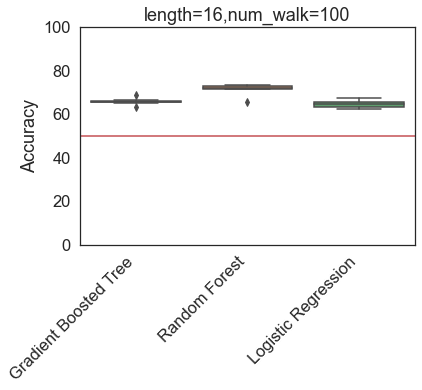

best accuracy 70


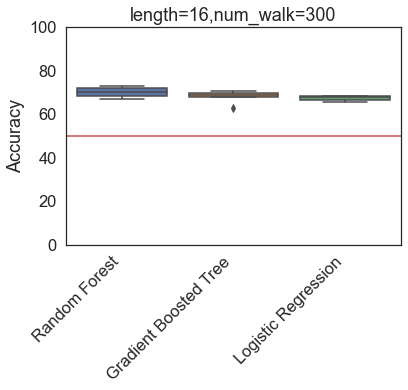

best accuracy 70


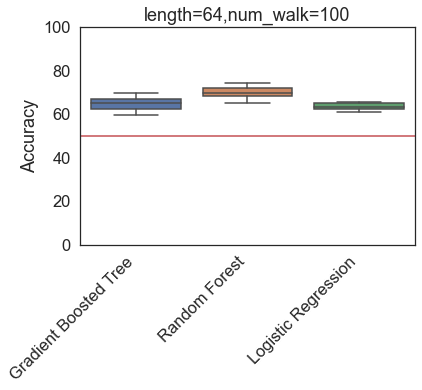

best accuracy 70


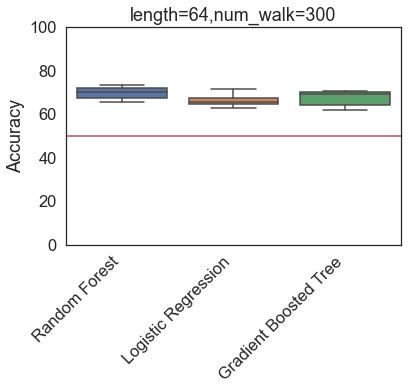

In [143]:
plot_ML_results(th_path, parameters)